<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_20_03_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [1]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [4]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [5]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.64MB/s]


In [6]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [7]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [8]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [9]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [10]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [11]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8230, Loss:  0.0029
Epoch	2	Acc:  0.8868, Loss:  0.0017
Epoch	3	Acc:  0.8957, Loss:  0.0015
Epoch	4	Acc:  0.9009, Loss:  0.0014
Epoch	5	Acc:  0.9043, Loss:  0.0014
Epoch	6	Acc:  0.9068, Loss:  0.0013
Epoch	7	Acc:  0.9091, Loss:  0.0013
Epoch	8	Acc:  0.9107, Loss:  0.0013
Epoch	9	Acc:  0.9122, Loss:  0.0012
Epoch	10	Acc:  0.9134, Loss:  0.0012
Task 0 Acc:  0.9174, Loss:  0.0012
Task 1 Acc:  0.1500, Loss:  0.0207

Task 1 Start!
Epoch	1	Acc:  0.5502, Loss:  0.0080
Epoch	2	Acc:  0.6892, Loss:  0.0059
Epoch	3	Acc:  0.7067, Loss:  0.0056
Epoch	4	Acc:  0.7165, Loss:  0.0055
Epoch	5	Acc:  0.7219, Loss:  0.0054
Epoch	6	Acc:  0.7249, Loss:  0.0054
Epoch	7	Acc:  0.7275, Loss:  0.0054
Epoch	8	Acc:  0.7284, Loss:  0.0053
Epoch	9	Acc:  0.7300, Loss:  0.0053
Epoch	10	Acc:  0.7310, Loss:  0.0053
Task 0 Acc:  0.6882, Loss:  0.0038
Task 1 Acc:  0.7341, Loss:  0.0034



 - Task 0

Accuracy 0.6882
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.84      0.78      0.81       980
     1 - one       0.98      0.74      0.85      1135
     2 - two       0.61      0.59      0.60      1032
   3 - three       0.74      0.84      0.79      1010
    4 - four       0.40      0.75      0.53       982
    5 - five       0.80      0.41      0.54       892
     6 - six       0.71      0.88      0.79       958
   7 - seven       0.94      0.54      0.69      1028
   8 - eight       0.65      0.59      0.62       974
    9 - nine       0.64      0.72      0.68      1009

    accuracy                           0.69     10000
   macro avg       0.73      0.69      0.69     10000
weighted avg       0.74      0.69      0.69     10000



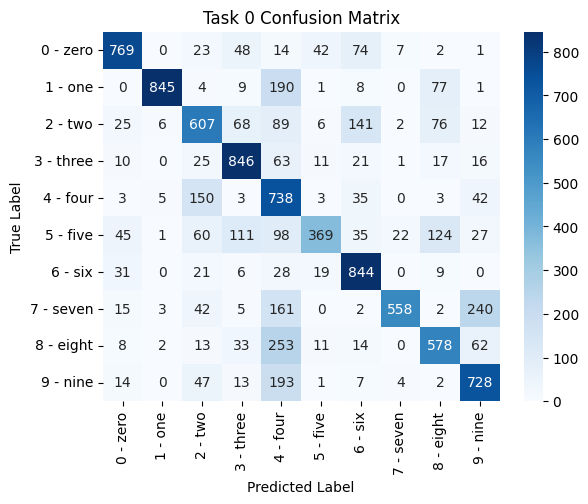

In [12]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7341
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.89      0.95      0.92       980
     1 - one       0.88      0.93      0.90      1135
     2 - two       0.81      0.65      0.72      1032
   3 - three       0.56      0.59      0.57      1010
    4 - four       0.72      0.66      0.69       982
    5 - five       0.53      0.44      0.48       892
     6 - six       0.82      0.85      0.84       958
   7 - seven       0.85      0.83      0.84      1028
   8 - eight       0.54      0.60      0.57       974
    9 - nine       0.70      0.79      0.74      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



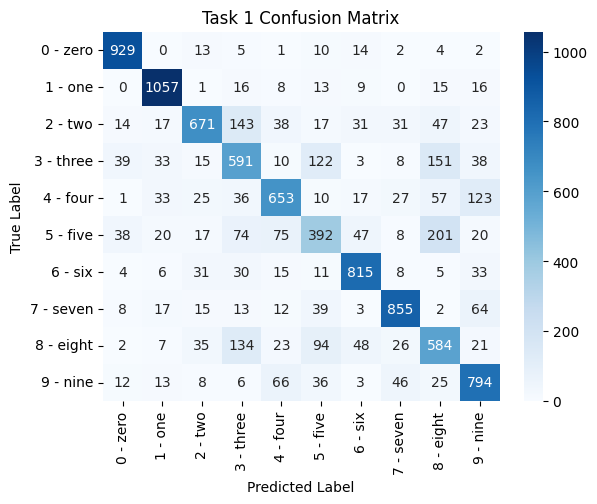

In [13]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.00765 and it's parameter diff is 0.01907
Min Parameter diff is 0.53084 and it's fisher is 0.00017
fisher > parameter diff: 43
fisher <= parameter diff: 741


<Figure size 640x480 with 0 Axes>

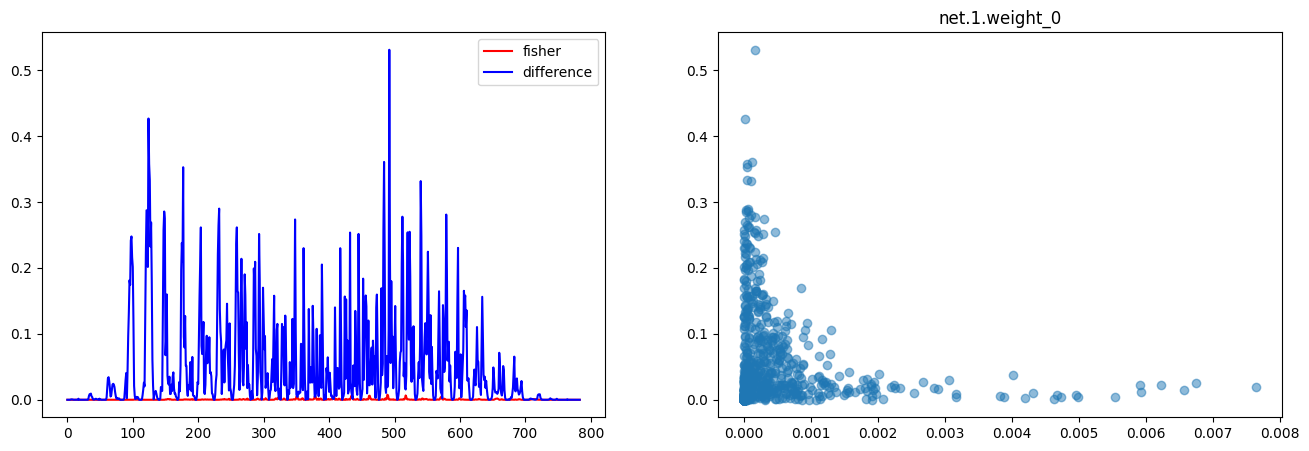

Max fisher is 0.01708 and it's parameter diff is 0.00356
Min Parameter diff is 0.93356 and it's fisher is 0.00003
fisher > parameter diff: 73
fisher <= parameter diff: 711


<Figure size 640x480 with 0 Axes>

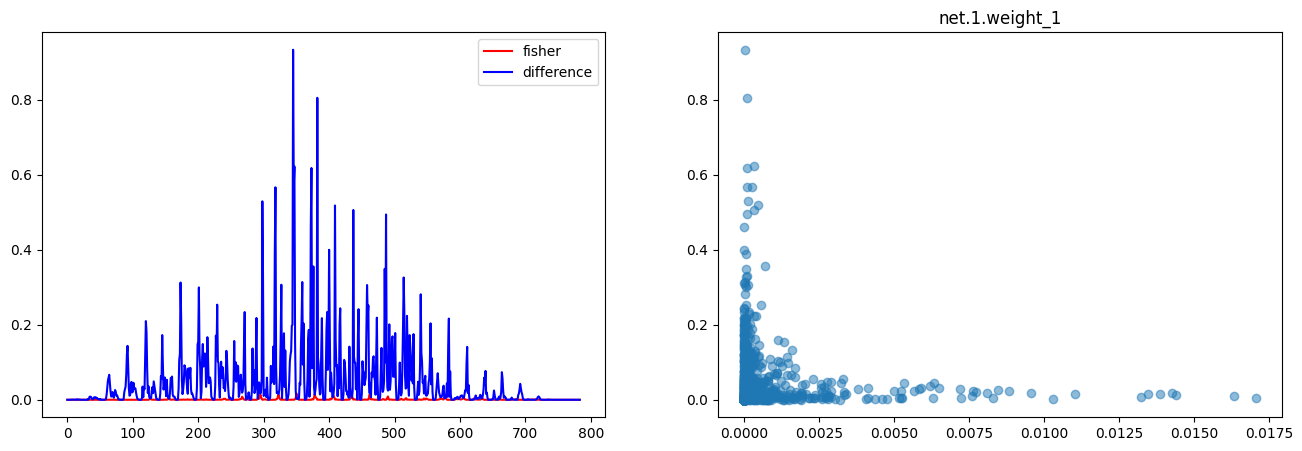

Max fisher is 0.01175 and it's parameter diff is 0.01480
Min Parameter diff is 0.69567 and it's fisher is 0.00012
fisher > parameter diff: 44
fisher <= parameter diff: 740


<Figure size 640x480 with 0 Axes>

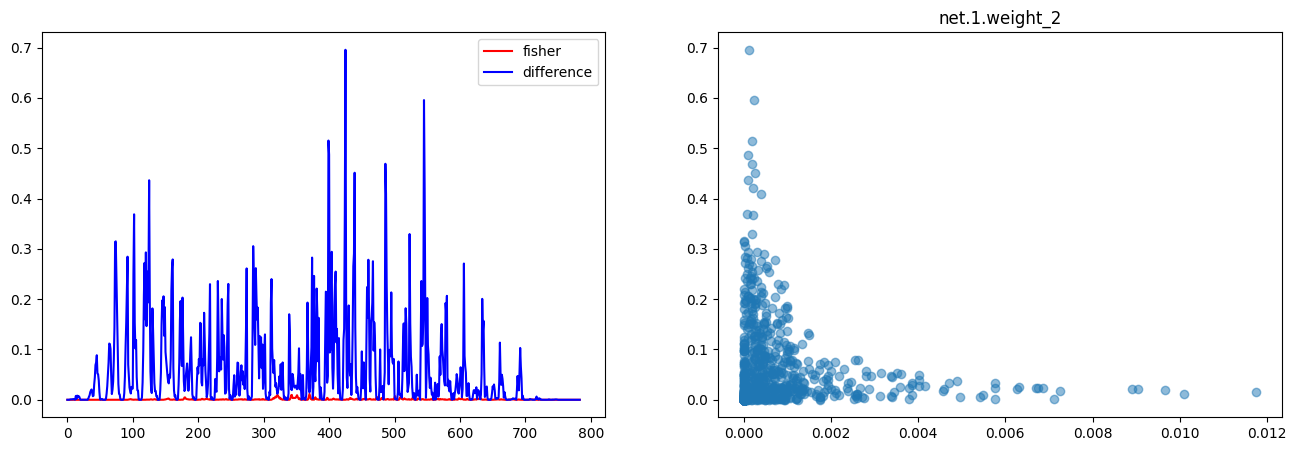

Max fisher is 0.04830 and it's parameter diff is 0.00542
Min Parameter diff is 0.86790 and it's fisher is 0.00003
fisher > parameter diff: 188
fisher <= parameter diff: 596


<Figure size 640x480 with 0 Axes>

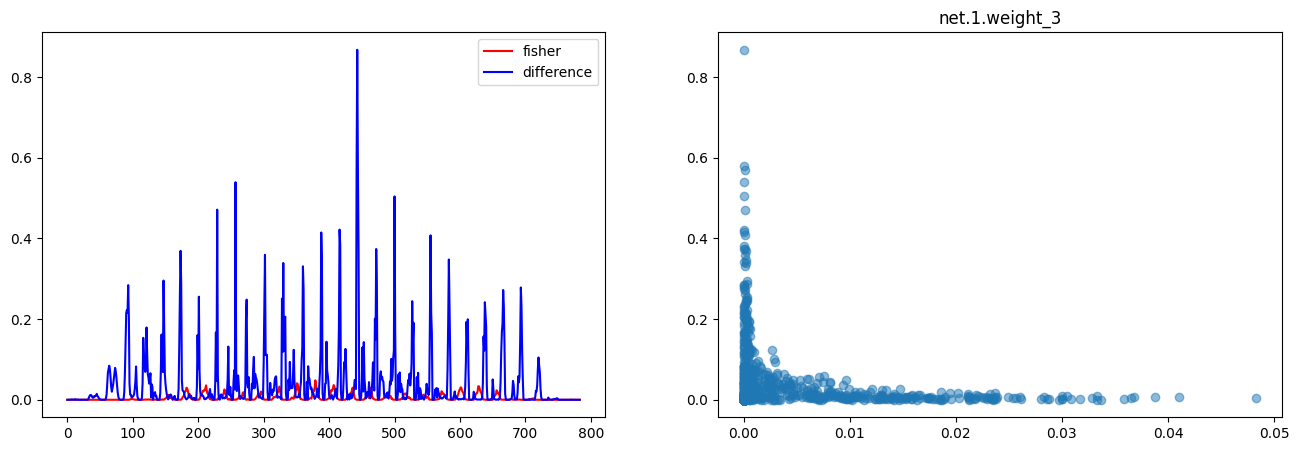

Max fisher is 0.01576 and it's parameter diff is 0.01704
Min Parameter diff is 0.80260 and it's fisher is 0.00016
fisher > parameter diff: 75
fisher <= parameter diff: 709


<Figure size 640x480 with 0 Axes>

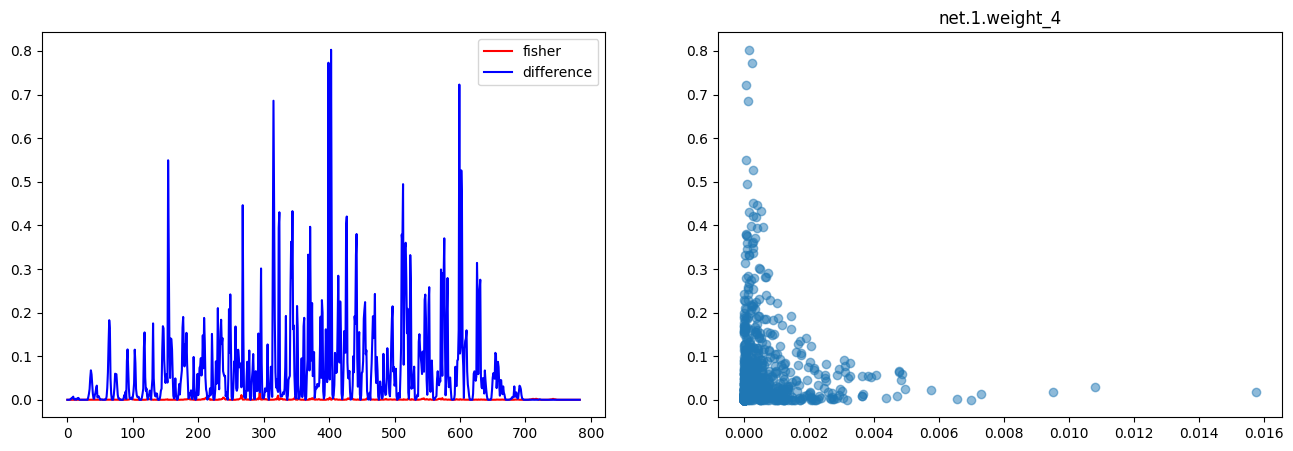

Max fisher is 0.01774 and it's parameter diff is 0.00661
Min Parameter diff is 1.22156 and it's fisher is 0.00001
fisher > parameter diff: 69
fisher <= parameter diff: 715


<Figure size 640x480 with 0 Axes>

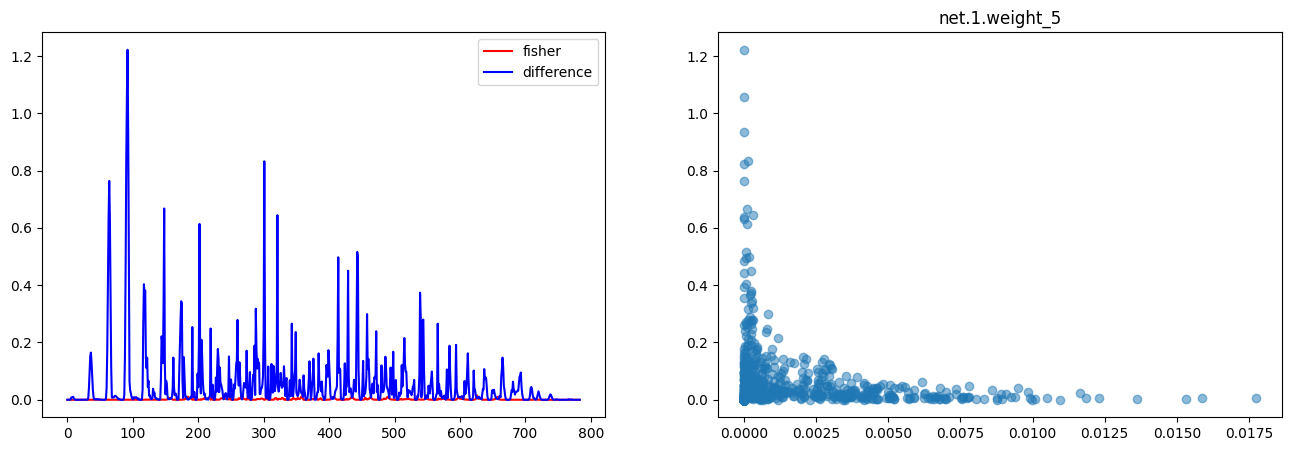

Max fisher is 0.00867 and it's parameter diff is 0.01680
Min Parameter diff is 0.70826 and it's fisher is 0.00007
fisher > parameter diff: 55
fisher <= parameter diff: 729


<Figure size 640x480 with 0 Axes>

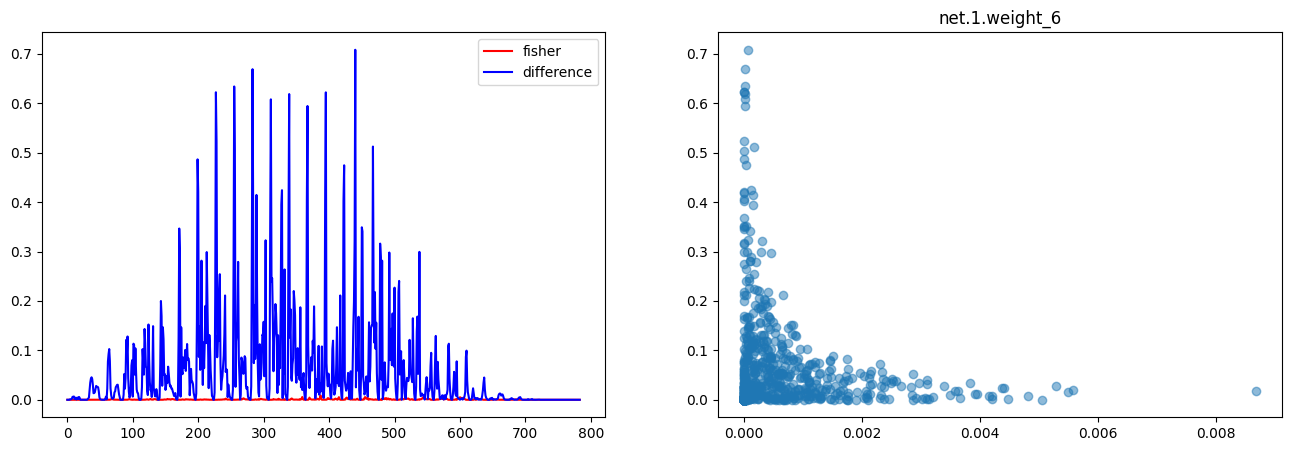

Max fisher is 0.01234 and it's parameter diff is 0.00613
Min Parameter diff is 0.56986 and it's fisher is 0.00003
fisher > parameter diff: 75
fisher <= parameter diff: 709


<Figure size 640x480 with 0 Axes>

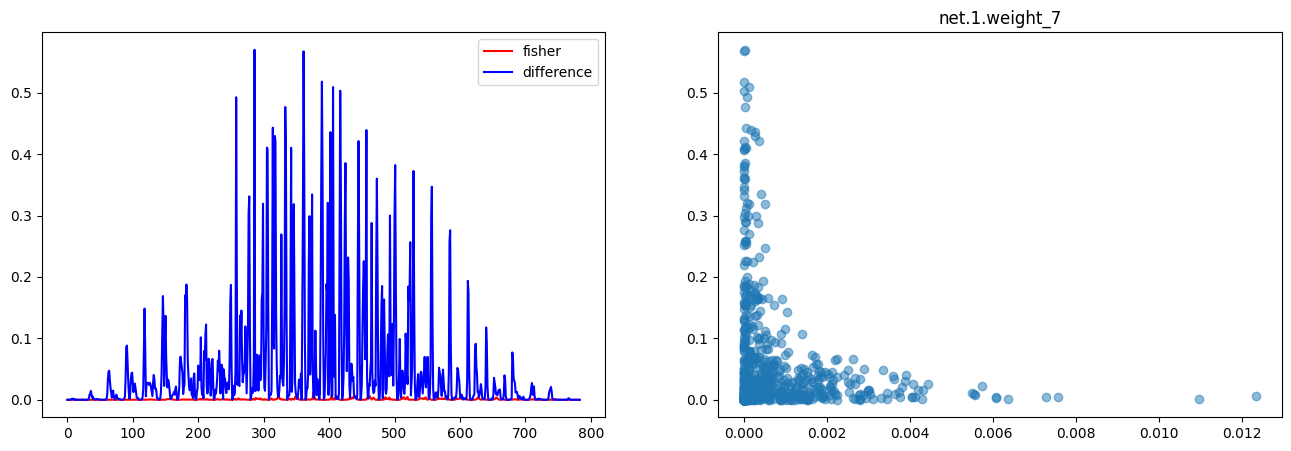

Max fisher is 0.06646 and it's parameter diff is 0.00029
Min Parameter diff is 0.59282 and it's fisher is 0.00001
fisher > parameter diff: 258
fisher <= parameter diff: 526


<Figure size 640x480 with 0 Axes>

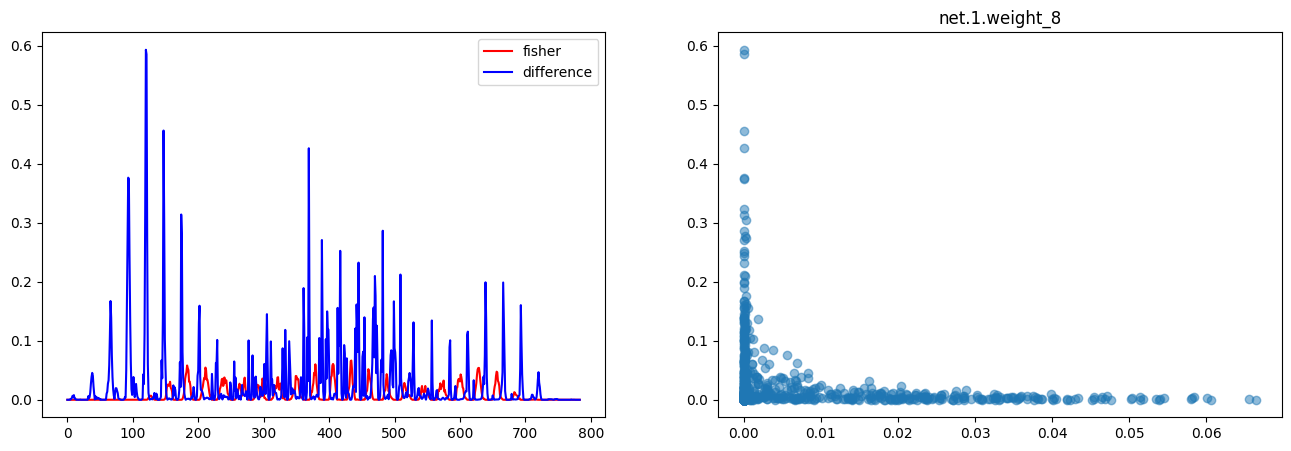

Max fisher is 0.01857 and it's parameter diff is 0.00680
Min Parameter diff is 0.63250 and it's fisher is 0.00009
fisher > parameter diff: 88
fisher <= parameter diff: 696


<Figure size 640x480 with 0 Axes>

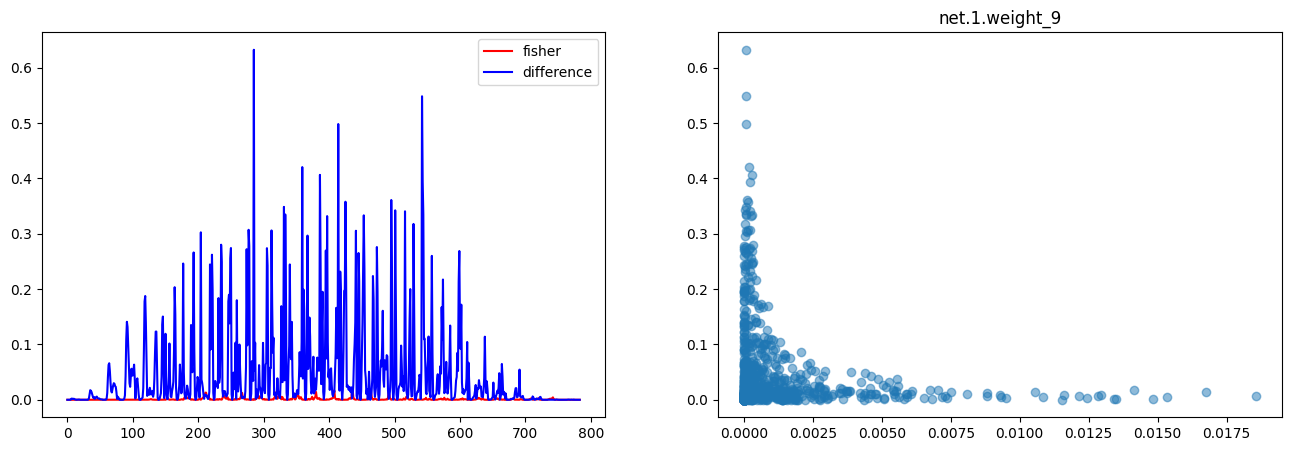


net.1.bias
torch.Size([10])
Max fisher is 0.11908 and it's parameter diff is 0.00034
Min Parameter diff is 0.10795 and it's fisher is 0.00148
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

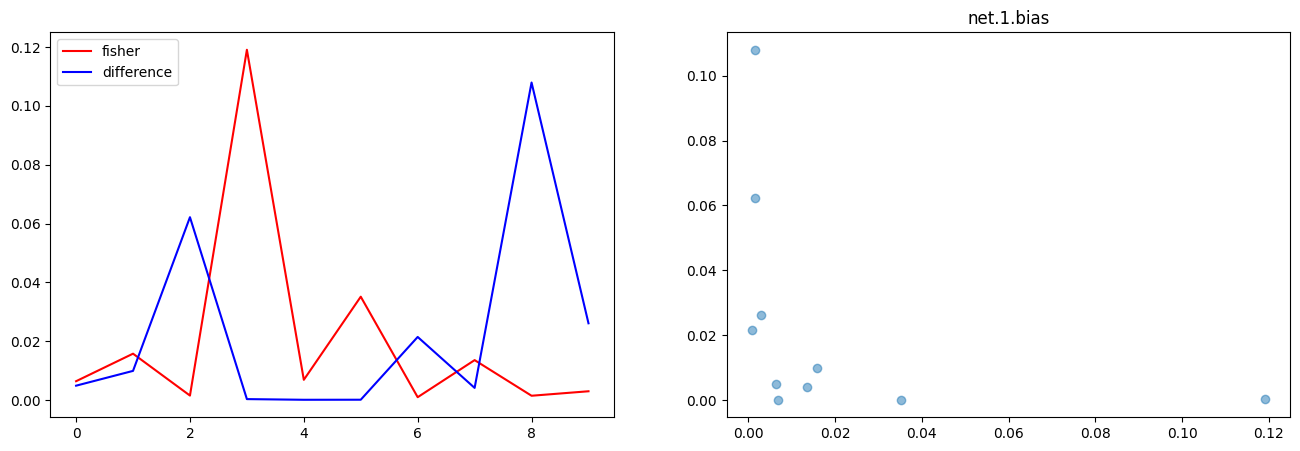

In [14]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [15]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-29_12_47_26
